In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from sklearn.cluster import KMeans

import skimage.data
from skimage.transform import resize
from skimage.util import img_as_ubyte
from skimage.color import gray2rgb

import cv2

import time
from itertools import product

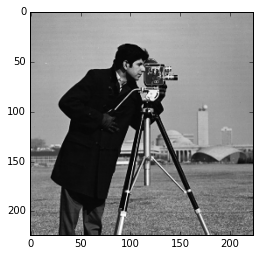

In [383]:
dataDir = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/patches/'
img = np.load(dataDir + '/patches_12N_105.npy')[0]

# img = gray2rgb(resize(skimage.data.camera(), (224,224)))

plt.imshow(img, cmap=plt.cm.gray);

In [384]:
vocabulary = np.load('/oasis/projects/nsf/csd395/ruogu/vocabulary/vocabulary.npy')

L = 3
M = vocabulary.shape[0]

kmeans = KMeans(init=vocabulary, n_clusters=M, n_init=1);
kmeans.fit(vocabulary);

In [385]:
sift = cv2.SIFT()
key_points, descriptor = sift.detectAndCompute(img_as_ubyte(img), None);
kp_pos_int = np.asarray([kp.pt for kp in key_points], np.int)

print len(key_points), 'keypoints'

280 keypoints


In [386]:
cluster_labels = kmeans.predict(descriptor)

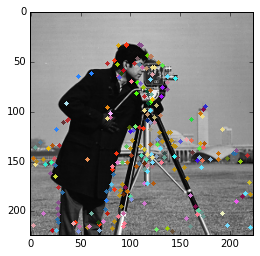

In [387]:
colors = (np.random.random((M,3))*255).astype(np.int)

viz = img.copy()

for (x,y), label in zip(kp_pos_int, cluster_labels):
    cv2.circle(viz, (x,y), 2, colors[label%colors.shape[0]], -1)
        
plt.imshow(viz, cmap=plt.cm.gray);

# Method 1
Suppose if multiple keypoints round to the same pixel, we want to count them as multiple.

In [380]:
t = time.time()

w = 224
h = 224

hists_allLevels = []
bboxes = [] # xmin, xmax, ymin, ymax, all inclusive

for l in range(3):
    grid_size_x = w/(2**(l+1))
    grid_size_y = h/(2**(l+1))
    x_grid_points = range(0, w, grid_size_x)
    y_grid_points = range(0, h, grid_size_y)

    n_grid_x = 2**(l+1)
    n_grid_y = 2**(l+1)
    
    n_grid = n_grid_x * n_grid_y

    for i, (x,y) in enumerate(product(x_grid_points, y_grid_points)):
        bboxes.append((x, x+grid_size_x-1, y, y+grid_size_y-1))

    hists = [np.zeros((M,), np.int) for _ in range(n_grid)]
        
#####################
# Fast method: compute the grid assignment for all keypoints directly
    grid_crs = kp_pos_int/[grid_size_x, grid_size_y]
    grid_cols = grid_crs[:,0]
    grid_rows = grid_crs[:,1]
    keypoint_grid_indices = (grid_rows-1) * n_grid_x + grid_cols

    for ki, label in zip(keypoint_grid_indices, cluster_labels):
        hists[ki][label] += 1

# Alternative method: build a grid_index_map same size as the immge,
# for regular grid, this is slower than above, but
# if grid is not regular (e.g. superpixels), this should be more efficient

#     grid_index_map = np.zeros((h,w), np.int)
#     for i, (x,y) in enumerate(product(x_grid_points, y_grid_points)):
#         grid_index_map[y:y+grid_size_y, x:x+grid_size_x] = i
#         bboxes.append((x, x+grid_size_x-1, y, y+grid_size_y-1))

#     for p, label in zip(kp_pos_int, cluster_labels):
#         hists[grid_index_map[p[1], p[0]]][label] += 1
#####################
    
    hists_allLevels.append(hists)

histograms_all = np.asarray([h for hs in hists_allLevels for h in hs])

print time.time() - t

0.00219392776489


# Method 2
Suppose we are being lazy, if multiple keypoints round to the same pixel, they will count as one.

First build a labelmap, then use `np.bincount()` over appropriate boxes.

In [381]:
t = time.time()

label_map = np.zeros(img.shape[:2], np.int)
for (x,y), label in zip(kp_pos_int, cluster_labels):
    label_map[y, x] = label + 1

print time.time() - t


t = time.time()

label_map = np.zeros(img.shape[:2], np.int)
label_map[kp_pos_int[:,1], kp_pos_int[:,0]] = cluster_labels + 1

print time.time() - t

# you can see using indexing trick is ten times faster than for-loop

0.00204014778137
0.000309944152832


In [382]:
t = time.time()

w = 224
h = 224

histograms_all = []
bboxes = [] # xmin, xmax, ymin, ymax, all inclusive

for l in range(3):
    grid_size_x = w/(2**(l+1))
    grid_size_y = h/(2**(l+1))
    x_grid_points = range(0, w, grid_size_x)
    y_grid_points = range(0, h, grid_size_y)

    for x in x_grid_points:
        for y in y_grid_points:
            hist = np.bincount(label_map[y:y+grid_size_y, x:x+grid_size_x].flat, minlength=M+1)[1:]
            histograms_all.append(hist)
            bboxes.append((x, x+grid_size_x-1, y, y+grid_size_y-1))
            
print time.time() - t

0.00235104560852
